# 1 - install dependencies

In [1]:
import numpy as np
import cv2 
import os
import mediapipe as mp
import tensorflow as tf 
from tensorflow import keras
import matplotlib.pyplot as plt
import time
import pandas as pd

# 2 - keypoints extractions and drawing

In [2]:
mp_holistic = mp.solutions.holistic
mp_drawing = mp.solutions.drawing_utils

num_hand_marks = 21
num_pose_marks = 33


# holistic model process image and return the results as keypoints
def mediapipe_detection(image,model):
    image  = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    image.flags.writeable = False
    results = model.process(image)
    image.flags.writeable = True
    image  = cv2.cvtColor(image,cv2.COLOR_RGB2BGR)
    return image,results
    
def draw_styled_landmarks(image,results):
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             ) 
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             ) 
    

# read the keypoints and extract them and process them
def extract_keypoints(results):
    # extract pose marks
    if results.pose_landmarks:
        pose = np.array([ [res.x,res.y,res.visibility] for res in results.pose_landmarks.landmark ]).flatten()
    else:
        pose = np.zeros(num_pose_marks*3)
    
    # extract left hand
    if results.left_hand_landmarks:
        left_hand = np.array([ [res.x,res.y] for res in results.left_hand_landmarks.landmark ]).flatten()
    else:
        left_hand = np.zeros(num_hand_marks*2)
        
        
    # extract right hand
    if results.right_hand_landmarks:
        right_hand = np.array([ [res.x,res.y] for res in results.right_hand_landmarks.landmark ]).flatten()
    else:
        right_hand = np.zeros(num_hand_marks*2)
    
    return np.concatenate([pose,left_hand,right_hand])
    

# 3 - read and process data

In [3]:
data_path = "../../../data/Datasets/"

train_labels = pd.read_csv(os.path.join(data_path,"train_labels.csv"),names=['sample','id'])
validation_labels = pd.read_csv(os.path.join(data_path,"validation_labels.csv"),names=['sample','id'])
test_labels = pd.read_csv(os.path.join(data_path,"test_labels.csv"),names=['sample','id'])
class_id = pd.read_csv(os.path.join(data_path,"class_id.csv"))


    
train_path = os.path.join(data_path,"train")
val_path = os.path.join(data_path,"val")
test_path = os.path.join(data_path,"test")



In [4]:
def check_file(file_path):
    try:
        f = open(file_path)
        f.close()
        return True
    except IOError:
        return False
    
    

def construct_path(file,path="train"):
    return os.path.join(os.path.join(data_path,path),file+"_color.mp4")
    

### 3.1 collect data that in classes 0,1,2 and available in the data/train directory

In [9]:
n_actions = 6
actions = list(class_id['EN'][:n_actions])

In [10]:
actions

['sister', 'hurry', 'hungry', 'enjoy_your_meal', 'brother', 'tree']

In [11]:
n_actions = 6
actions = list(class_id['EN'][:n_actions])
actions[3] = "meal"
dic={}
for i,action in enumerate(actions):
    dic[action]=i

In [12]:
dic

{'sister': 0, 'hurry': 1, 'hungry': 2, 'meal': 3, 'brother': 4, 'tree': 5}

In [13]:
def get_data(value,file_path,label_name):
    if file_path=="train":
        label_dic = train_labels
    elif file_path=="val":
        label_dic = validation_labels
    elif file_path=="test":
        label_dic = test_labels
        
    
    data =  label_dic[label_dic['id']==value]
    lis =  [construct_path(i,file_path) for i in  (data['sample'])]
    data =  [i for i in lis if check_file(i)]
    return data,[label_name for i in data]
    

    

In [14]:


d = [0,1,2,3,4,5]

def get_list(d,cat):
    arr_x=[]
    arr_y=[]
    for index,value in enumerate(d):
        
        data,labels = get_data(value,cat,index)
        arr_x.extend(data)
        arr_y.extend(labels)
    return arr_x,arr_y

train_X,train_Y = get_list(d,"train")
val_X,val_Y = get_list(d,"val")
test_X,test_Y = get_list(d,"test")


In [15]:
print(
    len(train_X ),
len(train_Y),
len(val_X ),
len(val_Y),
len(test_X ),
len(test_Y)
)

747 747 118 118 100 100


In [16]:
train_X[-1]

'../../../data/Datasets/train/signer42_sample383_color.mp4'

### 3.2 process videos into frames and label to cateogries

In [17]:


def capture_frames(video_path):
    video = cv2.VideoCapture(video_path)
    video_length = int(video.get(cv2.CAP_PROP_FRAME_COUNT)) - 1
    # count = 0
    # frame_rate = video.get(cv2.CAP_PROP_FRAME_COUNT)

    count=0
    frames = []
    while video.isOpened():
      # frame_id = video.get(0)
        ret, frame = video.read()
        
        if not ret:
            continue
        frames.append(frame)
        count += 1
        # If there are no more frames left
        if (count > (video_length-1)):
          # Release the feed
          video.release()
        # if frame_id % math.floor(1) == 0:
        #     file_name = f"{video_path}_frame_{count}.jpg"
        #     count += 1
        #     # print(f"File name: {file_name}")
        #     frames.append(frame)
        #     # cv2.imwrite(file_name, frame)
    video.release()
    return np.array(frames)


def get_frames(video_path,num_frames):
    frames = capture_frames(video_path)
    video_length = len(frames)
    steps = video_length/num_frames
    count=0
    new_frames=[]
    while count<video_length:
        frame = frames[int(count)]
#         frame = cv2.resize(frame, (256, 256))
#         frame =  (frame/255.0).astype(np.float16)
        new_frames.append(frame)
        count+=steps

    s = np.array(new_frames[:num_frames])
    return np.array(new_frames[:num_frames])


In [18]:
def extract_keypoints_video(path,i=-1):
    
    if(i!=-1):
        print(i,end="\r")
    
    if(type(path) == str):
        frames = get_frames(path,20)
    else:
        frames = path
    output_key_points=[]
    with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
        for frame in frames:
            image, results = mediapipe_detection(frame, holistic)
            output_key_points.append(extract_keypoints(results))
    return np.array(output_key_points)


    

### 3.3 - extract the keypoints and save them in train

In [19]:
x = extract_keypoints_video(train_X[0])

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [20]:
if f"train_features__without_z.npy" in os.listdir():
    train_data = np.load("train_features__without_z.npy")
    val_data = np.load("val_features__without_z.npy")
    test_data = np.load("test_features__without_z.npy")
    train_labels = np.load("train_labels__without_z.npy")
    val_labels = np.load("val_labels__without_z.npy")
    test_labels = np.load("test_labels__without_z.npy")
else:
    train = np.array([extract_keypoints_video(path,f'Train iteration : {i+1}/{len(train_X)}') for i,path in enumerate(train_X) ])
    np.save('train_features__without_z.npy', train) 
    print("Training Finished")
    val = np.array([extract_keypoints_video(path,f'Valdiation iteration : {i+1}/{len(val_X)}') for i,path in enumerate(val_X) ])
    np.save('val_features__without_z.npy', val) 
    print("Validation Finished")
    test = np.array([extract_keypoints_video(path,f'Test iteration : {i+1}/{len(test_X)}') for i,path in enumerate(test_X) ])
    np.save('test_features__without_z.npy', test)
    print("Test Finished")
    np.save("train_labels__without_z.npy",np.array(train_Y))
    np.save("val_labels__without_z.npy",np.array(val_Y))
    np.save("test_labels__without_z.npy",np.array(test_Y))

In [21]:
print(
train_data.shape,
    train_labels.shape,
    val_data.shape,
    val_labels.shape,
    test_data.shape,
    test_labels.shape
    
)

(747, 20, 183) (747,) (118, 20, 183) (118,) (100, 20, 183) (100,)


### 3.4 shuffle the data

In [22]:
perm = np.random.permutation(len(train_data))

train_X = train_data[perm]
train_Y = train_labels[perm]
val_X = val_data
val_Y = val_labels
test_X = test_data
test_Y = test_labels


In [23]:
print(
train_X.shape,
train_Y.shape,
val_X.shape,
val_Y.shape,
test_X.shape,
test_Y.shape,
)

(747, 20, 183) (747,) (118, 20, 183) (118,) (100, 20, 183) (100,)


# 4 - build and train the model

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense,Input,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import TensorBoard,ModelCheckpoint,EarlyStopping


tb_callback = TensorBoard(log_dir=os.path.join('Logs'))
checkpoint = ModelCheckpoint("best_model_without_z.h5", monitor='loss', verbose=0,
    save_best_only=True, mode='auto', save_freq=1)
earlyStopping = EarlyStopping(monitor='loss', patience=20)

In [25]:
def first_model():
    input_layer = Input(shape=(20,183))
    layer = LSTM(64,return_sequences=True,activation="relu")(input_layer)
    layer = LSTM(128,return_sequences=True,activation="relu")(layer)
    layer = LSTM(256,return_sequences=True,activation="relu")(layer)
    layer = LSTM(128,return_sequences=True,activation="relu")(layer)
    layer = LSTM(64,return_sequences=False,activation="relu")(layer)
    layer = Dense(64,activation="relu")(layer)
    layer = Dense(32,activation="relu")(layer)
    layer = Dense(len(actions),activation="softmax")(layer)

    model = Model(inputs=input_layer,outputs=layer)
    model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    
    return model


def second_model():
    input_layer = Input(shape=(20,183))
    layer = LSTM(64,return_sequences=True,activation="relu")(input_layer)
    layer = LSTM(128,return_sequences=True,activation="relu")(layer)
    layer = Dropout(0.3)(layer)
    layer = LSTM(128,return_sequences=True,activation="relu")(layer)
    layer = Dropout(0.3)(layer)
    layer = LSTM(64,return_sequences=False,activation="relu")(layer)
    layer = Dense(64,activation="relu")(layer)
    layer = Dense(32,activation="relu")(layer)
    layer = Dense(len(actions),activation="softmax")(layer)

    model = Model(inputs=input_layer,outputs=layer)
    model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    
    return model

def third_model():
    input_layer = Input(shape=(20,183))
    layer = LSTM(64,return_sequences=True,activation="relu")(input_layer)
    layer = LSTM(128,return_sequences=True,activation="relu")(layer)
    layer = LSTM(96,return_sequences=False,activation="relu")(layer)
    layer = Dense(64,activation="relu")(layer)
    layer = Dense(32,activation="relu")(layer)
    layer = Dense(len(actions),activation="softmax")(layer)

#     optimizer = tf.keras.optimizers.Nadam(learning_rate=0.002,
#                              beta_1=0.9,
#                              beta_2=0.999, 
#                              epsilon=1e-08,
#                              schedule_decay=0.004)
    
    model = Model(inputs=input_layer,outputs=layer)
    model.compile(optimizer="Adam", loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model


model = third_model()

2021-12-31 18:47:10.323453: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-31 18:47:10.327113: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-31 18:47:10.327410: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-31 18:47:10.327814: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [26]:
# model.load_weights('best_model.h5')

In [27]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 20, 183)]         0         
                                                                 
 lstm (LSTM)                 (None, 20, 64)            63488     
                                                                 
 lstm_1 (LSTM)               (None, 20, 128)           98816     
                                                                 
 lstm_2 (LSTM)               (None, 96)                86400     
                                                                 
 dense (Dense)               (None, 64)                6208      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 6)                 198   

In [42]:
history = model.fit(train_X, train_Y, epochs=400, callbacks=[tb_callback,checkpoint,earlyStopping],validation_data=(val_X,val_Y))

Epoch 1/400
24/24 [==============================] - 3s 135ms/step - loss: 0.2070 - accuracy: 0.8983 - val_loss: 0.7453 - val_accuracy: 0.8220
Epoch 2/400
24/24 [==============================] - 3s 132ms/step - loss: 0.3924 - accuracy: 0.8380 - val_loss: 0.4442 - val_accuracy: 0.8220
Epoch 3/400
24/24 [==============================] - 3s 131ms/step - loss: 0.3124 - accuracy: 0.8675 - val_loss: 0.4421 - val_accuracy: 0.8220
Epoch 4/400
24/24 [==============================] - 3s 140ms/step - loss: 0.2437 - accuracy: 0.8876 - val_loss: 0.6815 - val_accuracy: 0.8390
Epoch 5/400
24/24 [==============================] - 4s 153ms/step - loss: 0.2300 - accuracy: 0.8849 - val_loss: 1.3566 - val_accuracy: 0.6525
Epoch 6/400
24/24 [==============================] - 3s 137ms/step - loss: 0.4094 - accuracy: 0.8447 - val_loss: 0.5647 - val_accuracy: 0.7712
Epoch 7/400
24/24 [==============================] - 4s 131ms/step - loss: 0.2499 - accuracy: 0.8862 - val_loss: 0.4986 - val_accuracy: 0.8305

In [28]:
model.load_weights('best_model_without_z.h5')

In [35]:
print(history.history.keys())
# summarize history for accuracy



dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


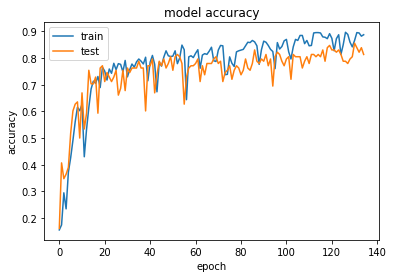

In [36]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

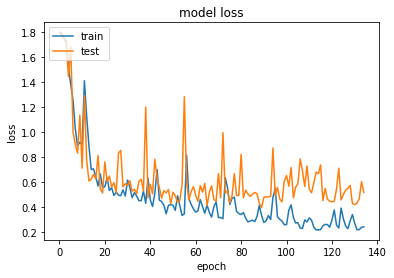

In [37]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [61]:
model.load_weights('best_model_without_z.h5')

In [56]:
m2.evaluate(train_X,train_Y)

24/24 [==============================] - 1s 7ms/step - loss: 0.1740 - accuracy: 0.9183


[0.17395444214344025, 0.9183400273323059]

In [44]:
model.evaluate(train_X,train_Y)

24/24 [==============================] - 0s 7ms/step - loss: 0.1989 - accuracy: 0.9103


[0.19889721274375916, 0.9103078842163086]

In [60]:
model.evaluate(val_X,val_Y)

4/4 [==============================] - 0s 8ms/step - loss: 0.6421 - accuracy: 0.8220


[0.6421167850494385, 0.8220338821411133]

In [59]:
model.evaluate(test_X,test_Y)

4/4 [==============================] - 0s 8ms/step - loss: 0.3852 - accuracy: 0.8400


[0.3851664364337921, 0.8399999737739563]

# 5 - test in real time

In [29]:
import numpy as np
import cv2 
import os
import mediapipe as mp
import tensorflow as tf 
from tensorflow import keras
import matplotlib.pyplot as plt
import time
import pandas as pd

In [30]:

def view_probability(res, actions, image):
    #output_frame = input_frame.copy()
    
    output_frame = image
    
    if(type(res)==list or type(res)==np.ndarray):
        max_prob_index = np.argmax(res)
        max_prob = res[max_prob_index]
        text = f'{actions[max_prob_index]} - {max_prob:.3f}'
    else:
        text = "not signing"
    
    
    cv2.rectangle(output_frame, (0,0), (640, 40), (0,255,0), -1)
    cv2.putText(output_frame, text, (0, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
    return output_frame



def view_sentence(sentence,image):
    # output_frame = image.copy()
    output_frame = image
    
    cv2.rectangle(output_frame, (0,430), (640, 480), (255, 0, 0), -1)
    cv2.putText(output_frame, ' '.join(sentence), (3,460), 
                   cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
    return output_frame


def compare_frames(prev_frame,current_frame,threshold):
    return True
    if(type(prev_frame) == np.ndarray ):
        diff = cv2.absdiff(prev_frame, current_frame)
        s = diff.sum()
        if(s > threshold):
            return True
        
    return False
    
def evaluate_list_comparisons(s):
    return True
    if(sum(s)>=2):
        return True
    return False

In [ ]:
# 1. New detection variables
sequence = []
sentence = []
predictions = []
threshold = 0.5

res = None

cap = cv2.VideoCapture(0)
# Set mediapipe model 

last_comparisons = []
holistic = mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5)
prev_frame = None
while cap.isOpened():

    ret, frame = cap.read()
    if(not ret):break
        
        
        
    comparison_result = compare_frames(prev_frame,frame,4000000)
    prev_frame = frame
    
    last_comparisons.append(int(comparison_result))
    last_comparisons = last_comparisons[-2:]
    
    
    

    image, results = mediapipe_detection(frame, holistic)
    draw_styled_landmarks(image, results)

    # 2. Prediction logic
    
    
    if(evaluate_list_comparisons(last_comparisons)):
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-20:]

        if len(sequence) == 20:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            predictions.append(np.argmax(res))


        #3. Viz logic
            if np.unique(predictions[-2:])[0]==np.argmax(res): 
                if res[np.argmax(res)] > threshold: 

                    if len(sentence) > 0: 
                        if actions[np.argmax(res)] != sentence[-1]:
                            sentence.append(actions[np.argmax(res)])
                    else:
                        sentence.append(actions[np.argmax(res)])

            if len(sentence) > 5: 
                sentence = sentence[-5:]
    else:
        res = None


    image = view_probability(res, actions, image)
    image = view_sentence(sentence,image)
    


    cv2.imshow('OpenCV Feed', image)

    # Break
    if cv2.waitKey(25) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

In [51]:
cap.release()

In [52]:
cv2.destroyAllWindows()

# 6-read video and predict it (for slower models)

In [33]:
def read_video_camera(n_frames,duration=3):
    import time
    
    frames = []
    
    cap = cv2.VideoCapture(0)
    start_time = time.time()
    while cap.isOpened():
        ret, frame = cap.read()
        if(not ret):break
        
        cv2.imshow("frame",frame)
        
        cv2.waitKey(20)
            
        frames.append(frame)
        if(time.time()-start_time > duration):
            break
    cap.release()
    cv2.destroyAllWindows()
    print(len(frames),n_frames)
    steps = len(frames)/n_frames
    count=0
    new_frames=[]
    while count < len(frames):
        frame = frames[int(count)]
        new_frames.append(frame)
        count+=steps
        
    
    return np.array(new_frames[:n_frames])
    
    
def view_video(video):
    for frame in video:
        cv2.imshow("frame",frame)
        cv2.waitKey(100)
    cv2.destroyAllWindows()
    
    
    

        


### read the video from Webcam

In [47]:
video = read_video_camera(n_frames=20,duration=3) # duration is for the human to take his time making the move

74 20


### view the video

In [48]:
view_video(video)

### make prediction

In [49]:
key_points = extract_keypoints_video(video)

In [50]:
predection_array = model.predict(np.expand_dims(key_points, axis=0))[0]
predection_id = np.argmax(predection_array)
predection_label = actions[predection_id]
predection_prob = predection_array[predection_id]
print(predection_label,predection_prob)


tree 1.0


In [131]:
predection_array

array([0.00219467, 0.09042753, 0.15158355, 0.75396156, 0.00183264],
      dtype=float32)

In [104]:
actions

['sister', 'hurry', 'hungry', 'meal', 'tree']